# Starting info

- Our brand is Grotal

In [94]:
import importlib

import pandas as pd
import seaborn as sns
import daft as d
import matplotlib.pyplot as plt
import utils as ut

In [108]:
importlib.reload(ut)

<module 'utils' from '/Users/zakhar/Desktop/code/xttr-test-brands/utils.py'>

# Reading the file

In [2]:
df = pd.read_csv('test_brand_data.csv')
df2 = d.from_pandas(df)

# Datatype conversion

In [8]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
# Have a look at the data
print(df.head())

        date    brand  region  total_sales  total_items_count  \
0 2027-02-06  Словора  Москва   2679000.97              23299   
1 2027-01-02   Зефора  Москва   2567184.96              19403   
2 2027-02-27  Словора  Москва   2869078.09              22382   
3 2027-01-02   Каморн  Москва   2899584.85              26983   
4 2027-01-02  Словора  Москва   4758714.46              51520   

   total_receipts_count  total_stores_count  
0                 20085                 927  
1                 16886                 855  
2                 19289                 932  
3                 23316                 932  
4                 42814                 927  


# Potential metrics

the WHATs:
+ sales by brand/region -> who's selling more?
+ competitors -> who are our rivals?

now the WHYs:
- top gainer/loser regions for us
- unit economics in gainer/loser regions

- average items per receipt by brand/region
- average receipt value by brand/region -> are people spending more? are the prices rising?
- stores by brand over time -> opening or closing, expanding or shrinking?

# Let's make a dataframe with only the data from last 6 months

It will help us analyse the latest trends

In [96]:
df_hy = ut.slice_last_mo(df, 6)

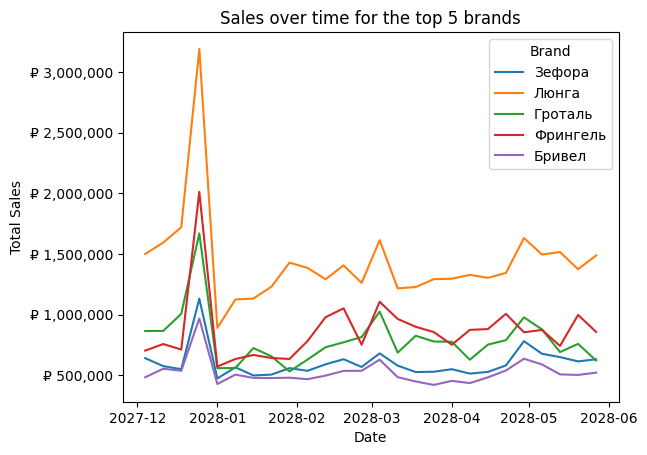

In [297]:
# Let's take top 5 brands by cumulative sales
top_5 = ut.get_top_brands(df_hy, 5)

# Draw line chart of sales over time for the top 5 brands

# Top 5 brands' indices
top_5 = top_5.index
df_top_brands = df_hy[df_hy['brand'].isin(top_5)]

# Chart without confidence intervals
top_brand_plot = sns.lineplot(data=df_top_brands, x='date', y='total_sales', hue='brand', errorbar=None)
# Format the x-axis
# top_brand_plot.set_xlim(three_months_ago, last_date)
# Format the labels
top_brand_plot.set(xlabel='Date', ylabel='Total Sales', title='Sales over time for the top 5 brands')
# Add a legend with a title
top_brand_plot.legend(title='Brand')
# Format the numbers as currency
top_brand_plot.yaxis.set_major_formatter('₽ {x:,.0f}')
# Rotate the x-axis labels
# top_brand_plot.set_xticklabels(top_brand_plot.get_xticklabels(), rotation=90)

We've ironed out the main rivals as:
- Зефора
- Люнга
- Гроталь
- Бривел
- Фрингель

P.S. We had a sharp drop in sales over the last several weeks, and our competitors (Fringel and Lunga) had sales rise.

Let's now dissect the sales for Grotal and Fringel and Lunga:
- by region
- by price

In [196]:
# Getting top 5 regions for the brand "Гроталь"
grotal = ut.get_top_regions(df_hy, 5, 'brand', 'region', 'total_sales', "Гроталь")

# Get the regions indices
grotal_regions = grotal.index.get_level_values(1)

# Get sales for Fringel in these regions
fringel = ut.get_top_regions(df_hy, 5, 'brand', 'region', 'total_sales', "Фрингель")
fringel_in_regions = df_hy[
    (df_hy['brand'] == "Фрингель") & 
    (df_hy['region'].isin(grotal_regions))
].groupby(['brand', 'region'])['total_sales'].sum()

# Get sales for Lunga in these regions
lunga_in_regions = df_hy[
    (df_hy['brand'] == "Люнга") & 
    (df_hy['region'].isin(grotal_regions))
].groupby(['brand', 'region'])['total_sales'].sum()

# Combine all results
top_regions = pd.concat([grotal, fringel_in_regions, lunga_in_regions]).reset_index()

top_regions.sort_values(by='total_sales', ascending=False, inplace=True)

# Now let's plot top regions for each brand

/var/folders/6s/xfrpp0xd2wlfbjl7gn_y82qw0000gn/T/ipykernel_90223/2936058652.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  top_regions_plot.set_xticklabels(top_regions_plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'Челябинская область'),
 Text(1, 0, 'Республика Башкортостан'),
 Text(2, 0, 'Пермский край'),
 Text(3, 0, 'Республика Татарстан (Татарстан)'),
 Text(4, 0, 'Ростовская область'),
 Text(5, 0, 'Краснодарский край'),
 Text(6, 0, 'Московская область'),
 Text(7, 0, 'Москва'),
 Text(8, 0, 'Воронежская область'),
 Text(9, 0, 'Саратовская область'),
 Text(10, 0, 'Рязанская область'),
 Text(11, 0, 'Тверская область')]

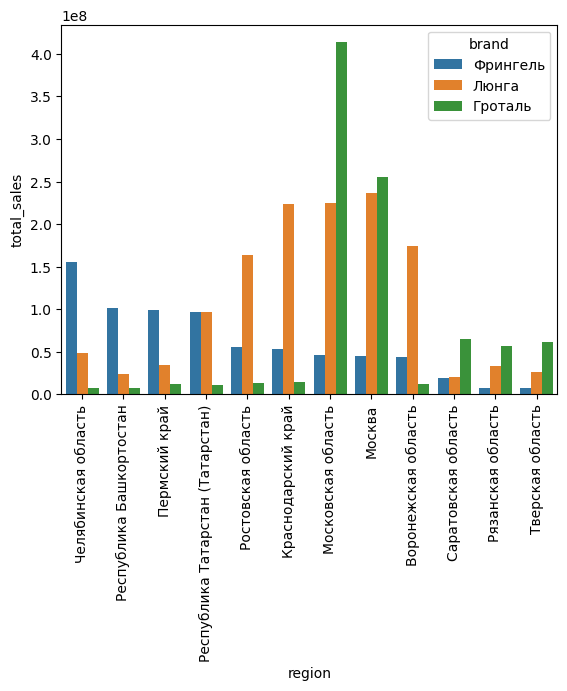

In [298]:
# Get respective sales for the top regions
fringel = ut.get_top_regions(df_hy, 5, 'brand', 'region', 'total_sales', "Фрингель")
lunga = ut.get_top_regions(df_hy, 5, 'brand', 'region', 'total_sales', "Люнга")

# Get the regions indices
fringel_regions = fringel.index.get_level_values(1)
lunga_regions = lunga.index.get_level_values(1)

# Concatenate all regions
region_indices = pd.concat([grotal, fringel, lunga]).reset_index()['region']

# Select the data for all the top regions
top_respective_regions = df_hy[(df_hy['region'].isin(region_indices)) & (df_hy['brand'].isin(['Гроталь', 'Фрингель', 'Люнга']))].groupby(['region', 'brand'])['total_sales'].sum().reset_index()

# Sort the values
top_respective_regions = top_respective_regions.sort_values(by=['brand', 'total_sales'], ascending=[False,False])

# Draw a bar chart
top_regions_plot = sns.barplot(data=top_respective_regions, x='region', y='total_sales', hue='brand')
# Rotate the x-axis labels by 90 degrees
top_regions_plot.set_xticklabels(top_regions_plot.get_xticklabels(), rotation=90)

# Top regions for Grotal in comparison

/var/folders/6s/xfrpp0xd2wlfbjl7gn_y82qw0000gn/T/ipykernel_90223/2111058676.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


[Text(0, 0, 'Московская область'),
 Text(1, 0, 'Москва'),
 Text(2, 0, 'Саратовская область'),
 Text(3, 0, 'Тверская область'),
 Text(4, 0, 'Рязанская область')]

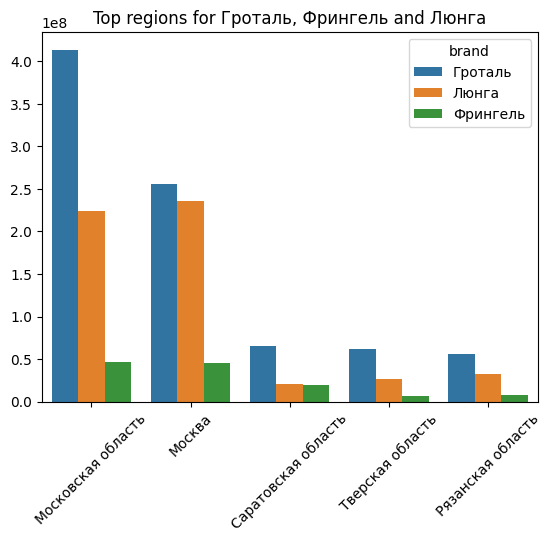

In [180]:
# Visualize top_regions
plot = sns.barplot(data=top_regions, x='region', y='total_sales', hue='brand')
# Set the title and labels
plot.set(xlabel='', ylabel='', title='Top regions for Гроталь, Фрингель and Люнга')
# Rotate the x-axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

# Region distribution for Grotal

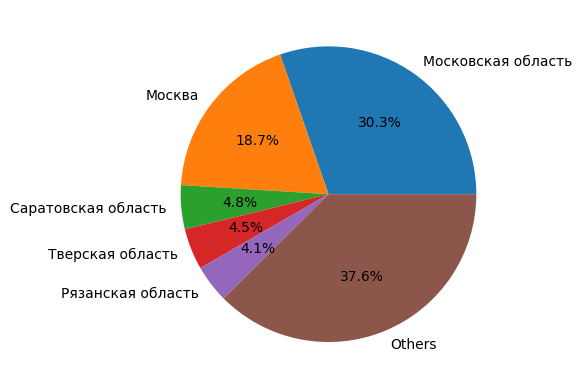

In [282]:
# Getting top 5 regions for Grotal over the last 6 months

# Calculate the sum of 5 regions with the highest sales
top_5_regions = df_hy[df_hy['brand'] == 'Гроталь']['total_sales'].groupby(df_hy['region']).sum().nlargest(5)

# Calculate total sales for Grotal
total_sales_grotal = df_hy[df_hy['brand'] == 'Гроталь']['total_sales'].groupby(df_hy['region']).sum()

# Concatenate the two series into a DataFrame. "Others" is sum of all regions not in the top 5
all_regions = pd.concat([top_5_regions, pd.Series({'Others': total_sales_grotal.sum() - top_5_regions.sum()})])

# Draw a pie chart
pie_chart = plt.pie(all_regions, labels=all_regions.index, autopct='%1.1f%%')

So, clearly Moscow and MO are leading the way.

# Top gainers and losers + average.

Or, who's growing the most?

In [213]:
# в каких регионах у меня выросли или упали продажи относительно конкурентов?

# Get the last 2 months of data
two_mos = ut.slice_last_mo(df, 2)

# Calculate monthly sales for each of the top brands for each of the 2 last months
monthly_sales = two_mos.groupby(['brand', pd.Grouper(key='date', freq='ME')])['total_sales'].sum().unstack()

In [214]:
monthly_sales['change'] = monthly_sales.pct_change(axis=1).iloc[:, 1] # Copilot suggested to use pct_change and iloc
# Format the numbers as percentages
# monthly_sales['change'] = monthly_sales['change'].map('{:.2%}'.format)
monthly_sales.head()

date,2028-04-30 00:00:00,2028-05-31 00:00:00,change
brand,,,
Брефора,1.208706e+07,1.064583e+07,-0.119237
Бривел,1.763778e+08,1.462637e+08,-0.170737
Венжера,7.366549e+06,5.945125e+06,-0.192957
Вунтель,4.734626e+07,3.734823e+07,-0.211168
Гирба,3.338615e+07,2.747130e+07,-0.177165


/var/folders/6s/xfrpp0xd2wlfbjl7gn_y82qw0000gn/T/ipykernel_90223/52186596.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  change_plot = sns.barplot(x=change_data, y=change_data.index, palette='viridis')


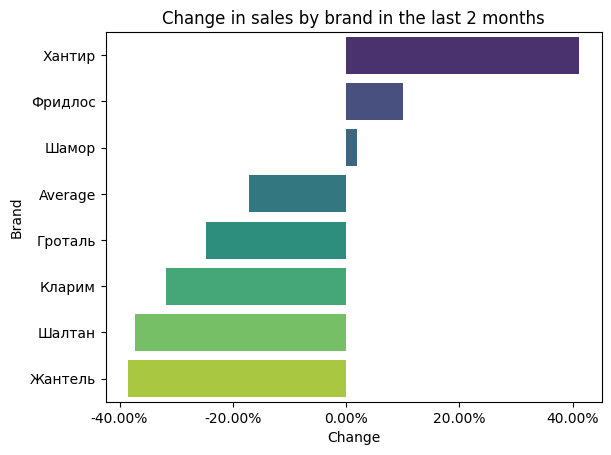

In [215]:
# Plot top 5, average, Гроталь and bottom 5 by change column as a horizontal bar chart
# Calculate the average change
average_change = monthly_sales['change'].mean()
# Add average change to the data
average_change = pd.Series(average_change, index=['Average'])
# Calculate the change for the top 5 brands
top_5 = monthly_sales['change'].nlargest(3).sort_values(ascending=False)
# Calculate the change for the bottom 5 brands
bottom_3 = monthly_sales['change'].nsmallest(3).sort_values(ascending=False)
# Grotal 
grotal_change = monthly_sales.loc['Гроталь', 'change']
grotal_change = pd.Series(grotal_change, index=['Гроталь'])
# Concatenate the data
change_data = pd.concat([top_5, average_change, grotal_change, bottom_3])
# Plot the data
change_plot = sns.barplot(x=change_data, y=change_data.index, palette='viridis')
# Format the labels
change_plot.set(xlabel='Change', ylabel='Brand', title='Change in sales by brand in the last 2 months')
# Format the numbers as percentages
change_plot.xaxis.set_major_formatter('{:.2%}'.format)
# Less ticks
change_plot.xaxis.set_major_locator(plt.MaxNLocator(5))

Looks that Hantir, Fridmos are. 

TODO: investigate

# Top/bottom regions for Grotal

/var/folders/6s/xfrpp0xd2wlfbjl7gn_y82qw0000gn/T/ipykernel_90223/157201997.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  change_plot = sns.barplot(x=change_data, y=change_data.index, palette='viridis').set(xlabel='', ylabel='', title='Change in sales for Гроталь in the last 2 months')


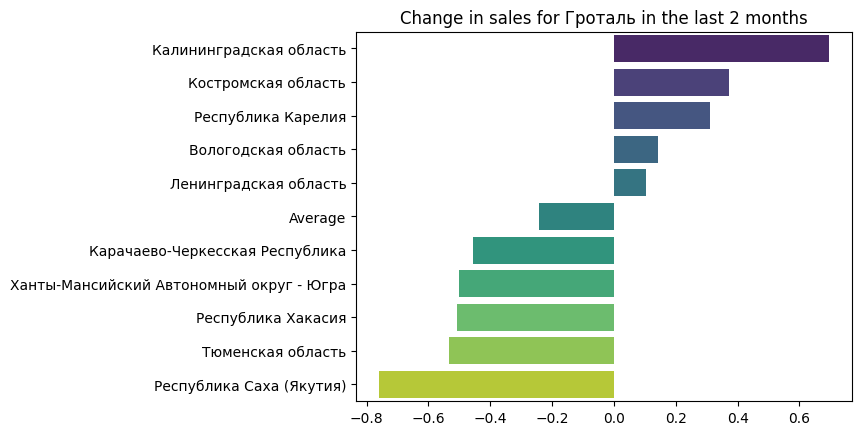

In [327]:
# Sales change 
grotal_monthly_sales = two_mos[two_mos['brand'] == 'Гроталь'].groupby(['region',pd.Grouper(key='date', freq='ME')])['total_sales'].sum().unstack()
grotal_monthly_sales['change'] = grotal_monthly_sales.pct_change(axis=1).iloc[:, 1]

# Calculate the average change
av = grotal_monthly_sales['change'].mean()
# Top 5 and bottom 5
top_5 = grotal_monthly_sales['change'].nlargest(5).sort_values(ascending=False)
bottom_5 = grotal_monthly_sales['change'].nsmallest(5).sort_values(ascending=False)

# Concatenate the data
change_data = pd.concat([top_5, pd.Series(av, index=['Average']), bottom_5])

# Plot the data
change_plot = sns.barplot(x=change_data, y=change_data.index, palette='viridis').set(xlabel='', ylabel='', title='Change in sales for Гроталь in the last 2 months')

# Preliminary insights

So, now we know:

- top brands by sales
- top regions for our and rivaling brands
- top gainers/losers among brands AND top gainers/losers among our regions (need to deduce why + *add top sales' regions*)

# Additional

In [ ]:
# Let's define some other metrics

# Items per receipt
df['items_per_receipt'] = df['total_items_count'] / df['total_receipts_count']
# Avg receipt value
df['avg_receipt_value'] = df['total_sales'] / df['total_receipts_count']
# Avg sales per store
df['sales_per_store'] = df['total_sales'] / df['total_stores_count']
# Average item price
df['avg_item_price'] = df['total_sales'] / df['total_items_count']